# Pipeline walkthrough

## Data import

In [1]:
from preprocessing.import_data import import_save_dataset

import napari

trim_series = True
lif_test_name = "test_data/2021-06-14/p2pdpwt"
lsm_test_name = "test_data/2023-04-07/p2pdp_zld-sites-ctrl_fwd_1"

(
    channels_full_dataset,
    original_global_metadata,
    original_frame_metadata,
    export_global_metadata,
    export_frame_metadata,
) = import_save_dataset(lsm_test_name, trim_series=trim_series, mode="tiff")

/home/ybadal/mambaforge/envs/transcription_pipeline/lib/python3.10/site-packages/pims/bioformats.py:410: UserWarning: Due to an issue with JPype 0.6.0, reading is slower. Please consider upgrading JPype to 0.6.1 or later.
  warn('Due to an issue with JPype 0.6.0, reading is slower. '
/home/ybadal/Documents/Berkeley/github_repositories/transcription_pipeline/preprocessing/import_data.py:719: UserWarning: /home/ybadal/Documents/Berkeley/github_repositories/transcription_pipeline/test_data/2023-04-07/p2pdp_zld-sites-ctrl_fwd_1/collated_dataset/collated_dataset_ch00.tiff is a low contrast image
  imsave(collated_data_path, channel_data, plugin="tifffile")
/home/ybadal/Documents/Berkeley/github_repositories/transcription_pipeline/preprocessing/import_data.py:719: UserWarning: /home/ybadal/Documents/Berkeley/github_repositories/transcription_pipeline/test_data/2023-04-07/p2pdp_zld-sites-ctrl_fwd_1/collated_dataset/collated_dataset_ch01.tiff is a low contrast image
  imsave(collated_data_path

In [2]:
nuclear_channel_metadata = export_frame_metadata[1]
nuclear_channel = channels_full_dataset[1]

## Starting a Dask Client for parallelization

In [3]:
from nuclear_analysis import segmentation
from tracking import track_features, detect_mitosis

import numpy as np
from dask.distributed import LocalCluster, Client

In [4]:
cluster = LocalCluster(
    host="localhost",
    scheduler_port=8786,
    threads_per_worker=1,
    n_workers=12,
    memory_limit="4GB",
)

In [5]:
client = Client(cluster)

In [6]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 12,Total memory: 44.70 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:8786,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 44.70 GiB
Comm: tcp://127.0.0.1:43465,Total threads: 1
Dashboard: http://127.0.0.1:32927/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:46347,


## Nuclear segmentation and tracking

In [7]:
%%time

(
    denoised,
    denoised_futures,
    nuclear_channel_futures,
) = segmentation.denoise_movie_parallel(
    nuclear_channel,
    denoising="gaussian",
    denoising_sigma=3,
    client=client,
)

mask, mask_futures, _ = segmentation.binarize_movie_parallel(
    denoised_futures,
    thresholding="global_otsu",
    closing_footprint=segmentation.ellipsoid(3, 3),
    client=client,
    futures_in=False,
)

markers, markers_futures, _ = segmentation.mark_movie_parallel(
    *nuclear_channel_futures,  # Wrapped in list from previous parallel run, needs unpacking
    mask_futures,
    low_sigma=[3, 5.5, 5.5],
    high_sigma=[10, 14.5, 14.5],
    max_footprint=((1, 25), segmentation.ellipsoid(3, 3)),
    max_diff=1,
    client=client,
    futures_in=False,
)

marker_coords = np.array(np.nonzero(markers)).T

labels, labels_futures, _ = segmentation.segment_movie_parallel(
    denoised_futures,
    markers_futures,
    mask_futures,
    watershed_method="raw",
    min_size=200,
    client=client,
    futures_in=False,
)

num_nuclei_per_fov = {12: (30, 50), 13: (70, 100), 14: (140, 220)}

segmentation_dataframe, division_frames, nuclear_cycle = track_features.segmentation_df(
    labels,
    nuclear_channel,
    nuclear_channel_metadata,
    num_nuclei_per_fov=num_nuclei_per_fov,
    division_peak_height=0.1,
    min_time_between_divisions=10,
)

tracked_dataframe = track_features.link_df(
    segmentation_dataframe,
    search_range=15,
    # adaptive_stop=1,
    # adaptive_step=0.99,
    memory=0,
    pos_columns=["x", "y"],
    t_column="frame_reverse",
    velocity_predict=True,
    velocity_averaging=2,
    reindex=True,
)

centroids = np.unique(
    np.array(
        [
            [row["frame"] - 1, int(row["z"]), int(row["y"]), int(row["x"])]
            for _, row in tracked_dataframe.iterrows()
        ]
    ),
    axis=0,
)

mitosis_dataframe = detect_mitosis.construct_lineage(
    tracked_dataframe,
    pos_columns=["y", "x"],
    search_range_mitosis=35,
    # adaptive_stop=0.05,
    # adaptive_step=0.99,
    antiparallel_coordinate="collision",
    antiparallel_weight=None,
    min_track_length=3,
    image_dimensions=[256, 512],
    exclude_border=0.02,
    minimum_age=5,
)

reordered_labels, reordered_labels_futures, _ = track_features.reorder_labels_parallel(
    labels_futures,
    mitosis_dataframe,
    client=client,
    futures_in=False,
    futures_out=True,
)

Frame 2: 1 trajectories present.
CPU times: user 24.8 s, sys: 29.8 s, total: 54.6 s
Wall time: 3min 10s


Using the rule of thumb $r \approx \sigma \sqrt{2} \ (2D)$ and $r \approx \sigma \sqrt{3} \ (3D)$ as rough bounds for the kernels used for band-pass filtering seems to net a perfect segmentation.

## Spot segmentation and fitting

In [8]:
transcription_channel_metadata = export_frame_metadata[0]
transcription_channel = channels_full_dataset[0]

In [9]:
from spot_analysis import detection, fitting

In [10]:
%%time

spot_dataframe, spot_mask, bandpassed_movie = detection.detect_and_gather_spots(
    transcription_channel,
    frame_metadata=transcription_channel_metadata,
    low_sigma=[0.1, 0.5, 0.5],
    high_sigma=[3, 1.5, 1.5],
    threshold="triangle",
    min_size=6,
    connectivity=1,
    span=[5, 11, 11],
    pos_columns=["z", "y", "x"],
    return_bandpass=False,
    return_spot_mask=True,
    drop_reverse_time=True,
    client=client,
)

fitting.add_fits_spots_dataframe_parallel(
    spot_dataframe,
    sigma_x_y_guess=1.5,
    sigma_z_guess=2,
    client=client,
    amplitude_guess=None,
    offset_guess=None,
    method="trf",
    inplace=True,
)

CPU times: user 8.2 s, sys: 8.33 s, total: 16.5 s
Wall time: 43.8 s


## Spot filtering and tracking

In [11]:
from spot_analysis import track_filtering

In [12]:
%%time

track_filtering.track_and_filter_spots(
    spot_dataframe,
    nuclear_labels=reordered_labels_futures,
    sigma_x_y_bounds=(0, 2.5),
    sigma_z_bounds=(0.35, 2),
    expand_distance=2,
    search_range=20,
    memory=2,
    pos_columns=["y", "x"],
    t_column="frame_reverse",
    velocity_predict=True,
    velocity_averaging=None,
    min_track_length=3,
    choose_by="amplitude",
    min_or_max="maximize",
    client=client,
)

(
    reordered_spot_labels,
    reordered_spot_labels_futures,
    _,
) = track_features.reorder_labels_parallel(
    spot_mask,
    spot_dataframe,
    client=client,
    futures_in=False,
    futures_out=True,
)

Frame 167: 17 trajectories present.
CPU times: user 11.7 s, sys: 11.6 s, total: 23.3 s
Wall time: 43.7 s


It can be shown for an xy-symmetric Gaussian that
$$
\int_{\mathbb{R}^3} A e^{- \frac{x^2 + y^2}{2 \sigma_{xy}^2} - \frac{z^2}{2 \sigma_z^2}} \ dx \ dy \ dz = 2 \sqrt{2} A \pi^{3/2} \sigma_{xy}^2 \sigma_z
$$
where we have used notation consistent with that used in `spot_analysis.fitting`. We can therefore use simple algebraic manipulation of the fit parameters to estimate the spot intensities.

In [13]:
from spot_analysis import compile_data

In [14]:
compiled_dataframe = compile_data.compile_traces(
    spot_dataframe,
    nuclear_tracking_dataframe=mitosis_dataframe,
    compile_columns_nuclear=["nuclear_cycle", "division_time"],
)

In [15]:
compiled_dataframe

,particle,frame,t_s,intensity_from_fit,nuclear_cycle,division_time
0,1,"[82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 9...","[1429.7821395514761, 1446.4017570046917, 1463....","[25540.338393366874, 68682.3590293864, 121900....",14,1299.679660
1,2,"[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 3...","[390.20823597341115, 406.9279614150481, 423.28...","[41555.49991897737, 114601.00635528714, 179446...",13,332.753653
2,4,"[92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102...","[1598.5656637979707, 1615.927142259131, 1632.6...","[23380.82522561254, 60235.688018575114, 55347....",14,1185.900772
3,6,"[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3...","[499.9692761500573, 517.3482964728448, 533.544...","[35871.837332101866, 60289.60311456024, 76190....","[12, 13, 14]",9.421215
4,8,"[100, 101, 103, 105, 107, 108, 109, 110, 111, ...","[1733.18599874769, 1748.9085463180804, 1781.92...","[26624.67039676178, 20809.43588216069, 43080.8...",14,1188.338628
...,...,...,...,...,...,...
195,455,"[87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 9...","[1513.4246101351587, 1531.2467132503139, 1548....","[22546.621533274738, 48187.48857872356, 51003....",14,1201.047424
196,457,"[88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 9...","[1530.0629198457405, 1547.7252729781246, 1564....","[28779.05915647891, 31838.767187735084, 76679....",14,1220.247020
197,458,"[86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 9...","[1496.7371247414553, 1531.482723240012, 1548.6...","[26757.798012918483, 44905.02240988416, 55353....",14,1316.725237
198,459,"[88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 9...","[1530.1277743388719, 1547.1990889675494, 1563....","[54133.726812839195, 61480.46563198308, 115757...",14,1348.960424


## Visualizing traces

In [16]:
from utils import plottable

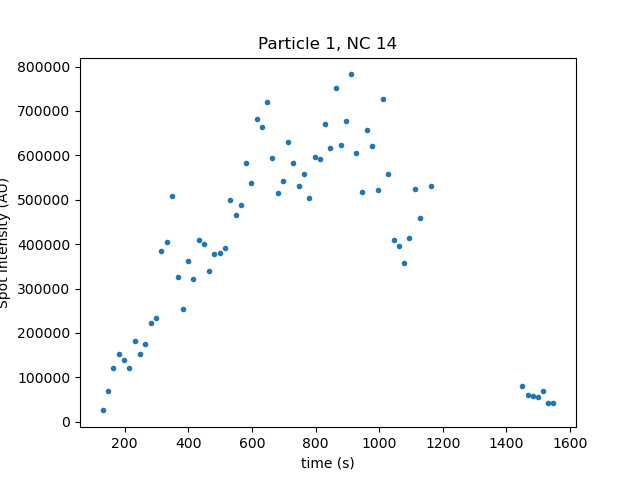

In [17]:
%matplotlib widget
# This is taken from https://stackoverflow.com/questions/18390461/scroll-backwards-and-forwards-through-matplotlib-plots
import matplotlib.pyplot as plt

traces = plottable.generate_trace_plot_list(compiled_dataframe)

curr_pos = 0


def key_event(e):
    global curr_pos

    if e.key == "right":
        curr_pos = curr_pos + 1
    elif e.key == "left":
        curr_pos = curr_pos - 1
    else:
        return
    curr_pos = curr_pos % len(traces)

    ax.cla()
    ax.plot(traces[curr_pos][0], traces[curr_pos][1], ".")
    ax.set_xlabel("time (s)")
    ax.set_ylabel("Spot intensity (AU)")
    ax.set_title(f"Particle {traces[curr_pos][2]}, NC {traces[curr_pos][3]}")
    fig.canvas.draw()


fig = plt.figure()
fig.canvas.mpl_connect("key_press_event", key_event)

ax = fig.add_subplot(111)
ax.plot(traces[curr_pos][0], traces[curr_pos][1], ".")
ax.set_xlabel("time (s)")
ax.set_ylabel("Spot intensity (AU)")
ax.set_title(f"Particle {traces[curr_pos][2]}, NC {traces[curr_pos][3]}")

plt.show()

In [18]:
viewer = napari.view_image(nuclear_channel, name="Nuclear Channel")
viewer.add_labels(reordered_labels)
_ = detect_mitosis.tracks_to_napari(
    viewer, mitosis_dataframe, name="nuclear_tracks", output=False
)
viewer.add_image(transcription_channel, name="Transcription Channel")
viewer.add_labels(reordered_spot_labels)
napari.run()

## Automatic parameter determination

In [221]:
import warnings
from nuclear_analysis import segmentation
import numpy as np


def choose_nuclear_analysis_parameters(nuclear_size, channel_global_metadata):
    """
    Chooses reasonable default parameters based on the physical size in each axis of
    the features being segmented in microns and the resolution of the imaging, queried
    from the global metadata corresponding to that image.

    :param nuclear_size: Size of features being segmented in each axis, in microns.
    :type nuclear_size: array-like
    :param dict channel_global_metadata: Dictionary of global metadata for the relevant
        channel, as output by `preprocessing.import_data.import_save_dataset`.
    :return: Dictionary of kwarg dicts corresponding to each function in the nuclear
        segmentation and tracking pipeline, in order:
        *`nuclear_analysis.segmentation.denoise_movie`
        *`nuclear_analysis.segmentation.binarize_movie`
        *`nuclear_analysis.segmentation.mark_movie`
        *`nuclear_analysis.segmentation.segment_movie`
        *`nuclear_analysis.segmentation.segmentation_df`
        *`nuclear_analysis.segmentation.link_df`
        *`nuclear_analysis.detect_mitosis.construct_lineage`
    :rtype: dict
    """
    # Query resolution of imaging to translate from physical size to pixels
    mppZ = channel_global_metadata["PixelsPhysicalSizeZ"]
    mppY = channel_global_metadata["PixelsPhysicalSizeY"]
    mppX = channel_global_metadata["PixelsPhysicalSizeX"]

    if mppY != mppX:
        warnings.warn(
            "".join(
                [
                    "Resolution is anisotropic in X and Y, segmentation",
                    " parameters should be handled manually.",
                ]
            )
        )

    nuclear_size_pixels = np.asarray(nuclear_size) / np.array([mppZ, mppY, mppX])

    image_dimensions = np.array(
        [
            channel_global_metadata["PixelsSizeZ"],
            channel_global_metadata["PixelsSizeY"],
            channel_global_metadata["PixelsSizeX"],
        ]
    )

    # Make dictionaries for parameters of `nuclear_analysis` functions.
    denoising_sigma = np.maximum(nuclear_size_pixels / 15, np.array([1, 2, 2]))
    denoise_params = {"denoising": "gaussian", "denoising_sigma": denoising_sigma}

    closing_footprint_dimensions = np.floor(
        np.maximum(nuclear_size_pixels / 10, 3)
    ).astype(int)
    closing_footprint = segmentation.ellipsoid(
        (closing_footprint_dimensions[1:]).max(), closing_footprint_dimensions[0]
    )
    binarize_params = {
        "thresholding": "global_otsu",
        "closing_footprint": closing_footprint,
    }

    # The guidelines for choosing DoG sigmas can be found here:
    # 10.1016/j.jsb.2009.01.004
    # We choose the ratio of the Gaussian kernels k=3 so as to perform a relatively
    # wide bandpass.
    k = 3
    low_sigma = nuclear_size_pixels * np.sqrt(
        ((k**2) - 1) / (2 * (k**2) * np.log(k))
    )
    high_sigma = low_sigma * k
    # The maximum number of iterations of max-dilations used to find the peaks in the
    # nuclear DoG is set to have a maximum effective footprint of lengthscale twice
    # that of the nuclear diameter to avoid stopping too early before spurious peaks
    # are removed. This corresponds to iterating the minimal-size footprint (3 px)
    # once for every pixel in the lengthcale of a feature since each iteration dilates
    # a maximum by 2 px.
    max_iter = np.ceil(nuclear_size_pixels[1:].max()).astype(int)
    max_footprint = (max_iter, segmentation.ellipsoid(3, 3))
    mark_params = {
        "low_sigma": low_sigma,
        "high_sigma": high_sigma,
        "max_footprint": max_footprint,
        "max_diff": 1,
    }

    volume_nucleus = (
        (4 / 3) * np.pi * np.prod(nuclear_size_pixels / 2)
    )  # Treat nucleus as ellipsoid
    min_size = volume_nucleus / 20
    segment_params = {"watershed_method": "raw", "min_size": min_size}

    # We use the number of nuclei per FOV to determine the nuclear cycle we're in.
    # This requires an estimate of the number of nuclei per square microns:
    num_nuclei_per_um2 = {12: (0.005, 0.009), 13: (0.012, 0.018), 14: (0.024, 0.040)}
    fov_area = np.prod(image_dimensions[1:]) * mppY * mppX
    num_nuclei_per_fov = {
        key: np.asarray(num_nuclei_per_um2[key]) * area for key in num_nuclei_per_um2
    }
    segmentation_df_params = {
        "num_nuclei_per_fov": num_nuclei_per_fov,
        "division_peak_height": 0.1,
        "min_time_between_divisions": 10,
    }

    # A search range of ~4.2 um seems to work very well for tracking nuclei in the XY
    # plane. 3D tracking is not as of now handled in the defaults and has to be
    # explicitly passes along with an appropriate search range
    search_range = 4.2 / mppY
    pos_columns = ["y", "x"]  # Tracking only in XY in case z-stack was adjusted
    t_column = "frame_reverse"  # Track reversed time to help with large accelerations
    link_df_params = {
        "search_range": search_range,
        "memory": 1,
        "pos_columns": pos_columns,
        "t_column": t_column,
        "velocity_predict": True,
        "velocity_averaging": 2,
        "reindex": True,
    }

    # The search range for sibling nuclei can be significantly larger, since only new
    # nuclei are considered as candidate at each linking step
    search_range_mitosis = search_range * 2
    construct_lineage_params = {
        "pos_columns": pos_columns,
        "search_range_mitosis": search_range_mitosis,
        "adaptive_stop": 0.05,
        "adaptive_step": 0.99,
        "antiparallel_coordinate": "collision",
        "antiparallel_weight": None,
        "min_track_length": 3,
        "image_dimensions": image_dimensions[1:],
        "exclude_border": 0.02,
        "minimum_age": 4,
    }

    default_params = {
        "denoise_params": denoise_params,
        "binarize_params": binarize_params,
        "mark_params": mark_params,
        "segment_params": segment_params,
        "segmentation_df_params": segmentation_df_params,
        "link_df_params": link_df_params,
        "construct_lineage_params": construct_lineage_params,
    }

    return default_params

In [222]:
test_params = choose_nuclear_analysis_parameters([8.2, 4.7, 4.7], export_global_metadata[0])

In [223]:
test_params

{'denoise_params': {'denoising': 'gaussian',
  'denoising_sigma': array([1.09333333, 2.        , 2.        ])},
 'binarize_params': {'thresholding': 'global_otsu',
  'closing_footprint': array([[[False,  True, False],
          [ True,  True,  True],
          [False,  True, False]],
  
         [[ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True]],
  
         [[False,  True, False],
          [ True,  True,  True],
          [False,  True, False]]])},
 'mark_params': {'low_sigma': array([10.4311061 , 14.40214583, 14.40214583]),
  'high_sigma': array([31.29331829, 43.20643748, 43.20643748]),
  'max_footprint': (23,
   array([[[False,  True, False],
           [ True,  True,  True],
           [False,  True, False]],
   
          [[ True,  True,  True],
           [ True,  True,  True],
           [ True,  True,  True]],
   
          [[False,  True, False],
           [ True,  True,  True],
           [False,  True, False]]])),
  'max_diff': 1},
 '

Rough outline for call structure:

Instantiate `track_nuclei` class with `track_nuclei(nuclear_channel)` and have methods available to call nuclear segmentation and tracking. Have the class save each important step to disk.

Instantiate `track_spots` class with `track_spots(transcription_channel, nuclear_labels)` and have methods available to call spot segmentation and tracking. Have the class save each important step to disk.

Instantiate `analyze_dataset` class that subclasses `track_nuclei` and `track_spots` and performs 1spot analysis, with `analyze_dataset(dataset, channel_assignment)` with methods available as per subclasses and for trace compilation.

We choose the diameter in xy to be 4.7 microns, and in z to be 8.2 microns as the median of our measurements.